In [2]:
import re #正则表达式
import sys #提供参数
import argparse #用于参数解析，帮助文档

In [ ]:
# 需要定义2个函数，1个是用于解析批量batch fasta序列文件的，也就是读入并整理fasta序列文件为1个字典
# 另外一个函数实际上就是主函数，调用fasta序列解读函数，然后再进行正则表达式的处理

def parse_fasta(fasta_file):
    """
    Function:
    从fasta序列文件中批量读取并处理蛋白质序列文件
    
    Args:
    fasta_file: str, fasta格式的蛋白质序列文件的路径,每一个蛋白质条目record的header最好是唯一的、连续的，经过处理之后的header字符串；
    比如说"ZK742.6        CE40734 WBGene00045277  status:Confirmed        UniProt:A3FPJ7  protein_id:ABN43077.1"，最好就处理打印出ZK742.6
    再比如说"sp|O60384|ZN861_HUMAN Putative zinc finger protein 861 OS=Homo sapiens OX=9606 GN=ZNF861P PE=5 SV=1"，最好也是处理打印出ZN861_HUMAN
    这些都可以在该函数中处理，也可以使用其他函数进行处理，然后获取clean id之后的fasta序列文件，再使用该函数；
    当然，如果不介意细节的话，可以直接将整个header都打印出来
    
    Returns:
    dict, 其中键是蛋白质的ID，值是蛋白质的氨基酸序列（字符串）
    
    """
    with open(fasta_file,"r") as file:
        sequences = {}
        # 存储最终蛋白质id+序列的字典
        current_id = None
        # 初始化每1个蛋白质record的id
        current_sequence = []
        # 初始化每一个蛋白质record的序列
        for line in file:
            line = line.strip() # 去除换行符，便于后续append之后真实合并
            if line.startswith(">"):
                if current_id:
                    sequences[current_id] = ''.join(current_sequence)
                    current_sequence = []
                parts = line[1:].split()
                current_id = parts[0]
            else:
                current_sequence.append(line)
            # 第1次初始化的时候，因为没有蛋白质id，所以只执行parts以及current_id部分，实际上就是读取">"字符之后依据空格分隔的第1部分，初始化了1个蛋白质id
            # 然后接下去我们序列收集的做法都是这样的：在遇到下一个record的">"之前，我们将每一行的suquence都append起来，直到遇到下一个蛋白质id，我们才合并前1个蛋白质id的sequence
        if current_id:
            sequences[current_id] = ''.join(current_sequence)
        # 当然，前面的处理方法是在最后一个record之后，没有再遇到下一个蛋白质id的时候，我们需要再次合并最后一个蛋白质id的sequence，也就是最后1个蛋白质record需要注意一下
        
    return sequences    
    # 返回最终的蛋白质id+序列的字典       
    

def main(fasta_file,output_file,regular_pattern="C.{2,4}C.{3}[LIVMFYWC].{8}H.{3,5}H"):
    """
    Funtion:
    使用前面定义的函数，解析fasta序列文件，然后使用正则表达式匹配蛋白质序列，最后将匹配到的蛋白质id、匹配到的序列、匹配到的序列的起始和终止位置写入到输出文件中
    
    Args:
    fasta_file: str, fasta格式的蛋白质序列文件的路径，要求同parse_fasta函数中的要求
    output_file: str, 输出文件的路径
    regular_pattern: str, 正则表达式的模式，用于匹配蛋白质序列，可以自定义，默认为"C.{2,4}C.{3}[LIVMFYWC].{8}H.{3,5}H"，即默认对C2H2 zinc finger domain进行匹配
    
    Returns:
    返回对输入fasta序列文件的正则表达式匹配结果，写入到输出文件中，即tsv文件，其中包含蛋白质id、匹配到的序列、匹配到的序列的起始和终止位置，1个蛋白质id可能有多个匹配到的序列，每个序列都会单独写入1行
    
    """
    protein_sequences = parse_fasta(fasta_file)
    # 解析批量蛋白质序列文件之后，获取蛋白质id+序列的字典
    
    with open(output_file, "w") as out:
        # 以写入模式打开输出文件
        out.write("Protein_ID\tStart\tEnd\tMatched_Sequence\n")
            
    for protein_id,current_protein_sequence in protein_sequences.items():
        current_protein_match = re.finditer(regular_pattern,current_protein_sequence)
        for match in current_protein_match:
            start = match.start() # 如果想要1-based的话，需要+1，即start = match.start()+1 
            end = match.end() # 如果想要1-based的话，需要+1，即end = match.end()+1
            matched_sequence = match.group()
            out.write(f"{protein_id}\t{start}\t{end}\t{matched_sequence}\n")
            
            
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description=
                                     "接受一个fasta文件，然后使用正则表达式匹配蛋白质序列，最后将匹配到的蛋白质id、匹配到的序列、匹配到的序列的起始和终止位置写入到输出文件中")
    parser.add_argument("--fasta_file", help=
                        "输入的蛋白质FASTA文件路径，要求是fasta格式，每一个蛋白质条目record的header最好是唯一的、连续的，经过处理之后的header字符串；不然就直接打印出整个header")
    parser.add_argument("--regular_pattern", help=
                        "正则表达式的模式，用于匹配蛋白质序列，可以自定义，默认为C.{2,4}C.{3}[LIVMFYWC].{8}H.{3,5}H，即默认对C2H2 zinc finger domain进行匹配")
    parser.add_argument("--output_file", help="输出结构域正则表达式匹配文件,建议为tsv文件格式")

    args = parser.parse_args()
    main(args.fasta_file, args.output_file, args.regular_pattern)

In [24]:
?re.findall

Signature: re.findall(pattern, string, flags=0)
Docstring:
Return a list of all non-overlapping matches in the string.

If one or more capturing groups are present in the pattern, return
a list of groups; this will be a list of tuples if the pattern
has more than one group.

Empty matches are included in the result.
File:      ~/miniconda3/envs/r-jupyter/lib/python3.13/re/__init__.py
Type:      function

In [27]:
result1 = re.search("C.{2,4}C.{3}[LIVMFYWC].{8}H.{3,5}H","MEGDAVEAIVEESETFIKGKERKTYQRRREGGQEEDACHLPQNQTDGGEVVQDVNSSVQMVMMEQLDPTLLQMKTEVMEGTVAPEAEAAVDDTQIITLQVVNMEEQPINIGELQLVQVPVPVTVPVATTSVEELQGAYENEVSKEGLAESEPMICHTLPLPEGFQVVKVGANGEVETLEQGELPPQEDPSWQKDPDYQPPAKKTKKTKKSKLRYTEEGKDVDVSVYDFEEEQQEGLLSEVNAEKVVGNMKPPKPTKIKKKGVKKTFQCELCSYTCPRRSNLDRHMKSHTDERPHKCHLCGRAFRTVTLLRNHLNTHTGTRPHKCPDCDMAFVTSGELVRHRRYKHTHEKPFKCSMCDYASVEVSKLKRHIRSHTGERPFQCSLCSYASRDTYKLKRHMRTHSGEKPYECYICHARFTQSGTMKMHILQKHTENVAKFHCPHCDTVIARKSDLGVHLRKQHSYIEQGKKCRYCDAVFHERYALIQHQKSHKNEKRFKCDQCDYACRQERHMIMHKRTHTGEKPYACSHCDKTFRQKQLLDMHFKRYHDPNFVPAAFVCSKCGKTFTRRNTMARHADNCAGPDGVEGENGGETKKSKRGRKRKMRSKKEDSSDSENAEPDLDDNEDEEEPAVEIEPEPEPQPVTPAPPPAKKRRGRPPGRTNQPKQNQPTAIIQVEDQNTGAIENIIVEVKKEPDAEPAEGEEEEAQPAATDAPNGDLTPEMILSMMDR")
print(result1)
print(result1.start(), result1.end())
print(result1.group())

<re.Match object; span=(267, 288), match='CELCSYTCPRRSNLDRHMKSH'>
267 288
CELCSYTCPRRSNLDRHMKSH


In [31]:
result2 = re.finditer("C.{2,4}C.{3}[LIVMFYWC].{8}H.{3,5}H","MEGDAVEAIVEESETFIKGKERKTYQRRREGGQEEDACHLPQNQTDGGEVVQDVNSSVQMVMMEQLDPTLLQMKTEVMEGTVAPEAEAAVDDTQIITLQVVNMEEQPINIGELQLVQVPVPVTVPVATTSVEELQGAYENEVSKEGLAESEPMICHTLPLPEGFQVVKVGANGEVETLEQGELPPQEDPSWQKDPDYQPPAKKTKKTKKSKLRYTEEGKDVDVSVYDFEEEQQEGLLSEVNAEKVVGNMKPPKPTKIKKKGVKKTFQCELCSYTCPRRSNLDRHMKSHTDERPHKCHLCGRAFRTVTLLRNHLNTHTGTRPHKCPDCDMAFVTSGELVRHRRYKHTHEKPFKCSMCDYASVEVSKLKRHIRSHTGERPFQCSLCSYASRDTYKLKRHMRTHSGEKPYECYICHARFTQSGTMKMHILQKHTENVAKFHCPHCDTVIARKSDLGVHLRKQHSYIEQGKKCRYCDAVFHERYALIQHQKSHKNEKRFKCDQCDYACRQERHMIMHKRTHTGEKPYACSHCDKTFRQKQLLDMHFKRYHDPNFVPAAFVCSKCGKTFTRRNTMARHADNCAGPDGVEGENGGETKKSKRGRKRKMRSKKEDSSDSENAEPDLDDNEDEEEPAVEIEPEPEPQPVTPAPPPAKKRRGRPPGRTNQPKQNQPTAIIQVEDQNTGAIENIIVEVKKEPDAEPAEGEEEEAQPAATDAPNGDLTPEMILSMMDR")
print(result2)
for match in result2:
    print(match.start(), match.end(), match.group())

267 288 CELCSYTCPRRSNLDRHMKSH
295 316 CHLCGRAFRTVTLLRNHLNTH
323 345 CPDCDMAFVTSGELVRHRRYKH
408 430 CYICHARFTQSGTMKMHILQKH
438 460 CPHCDTVIARKSDLGVHLRKQH
468 489 CRYCDAVFHERYALIQHQKSH
496 517 CDQCDYACRQERHMIMHKRTH
524 546 CSHCDKTFRQKQLLDMHFKRYH


In [ ]:
def main(fasta_file, output_file,window_size, threshold):  
    #默认输出为tsv格式
    sequences = parse_fasta(fasta_file)
    #调用parse_fasta函数来解析FASTA文件，并返回一个字典sequences，其中键是蛋白质的ID，值是蛋白质的氨基酸序列（字符串）
    
    #处理正电荷block、负电荷block区域输出文件
    with open(output_file, 'w') as csvfile:
    #使用with语句打开一个输出文件（需要自己提供参数命名，'w'表示以写入模式打开
        writer = csv.writer(csvfile, delimiter='\t')
        #创建一个csv.writer对象，用于将数据写入csv文件，delimiter='\t'表示使用制表符作为字段分隔符
        writer.writerow(['Protein_Name', 'charged_block_start', 'charged_block_end', 'charged_block_length','charged_block_sequence', 'charged_block_total_charge','charged_block_NCPR' ,'charged_block_type'])
        #写入表头，即列名
        for protein_name, sequence in sequences.items():
            #sequences是一个字典，键是蛋白质的ID，值是蛋白质的氨基酸序列，现在从值中获取charged block区域起点以及终点的元组对列表
            merged_results_acidic, merged_results_basic= sliding_window_for_charged_block(sequence.replace('\n', ''),window_size=window_size, threshold=threshold) 
            #.replace('\n', '')双重保证，如果前面fasta序列中没有去除换行符,sequence.replace('\n', '')
            
            for results in merged_results_acidic:
                writer.writerow([protein_name, results[0], results[1], results[2], results[3],results[4], results[5],'Acidic'])
            for results in merged_results_basic:
                writer.writerow([protein_name, results[0], results[1], results[2], results[3],results[4], results[5],'Basic'])

In [ ]:
# 当然，类似的函数我们的写法可以有很多：

import gzip
import sys

def parse_fasta(filename):
    """
    从FASTA文件中解析蛋白质序列并返回一个字典，其中键是蛋白质的ID，值是氨基酸序列。
    
    Args:
    filename: str, FASTA格式的蛋白质序列文件路径。
              如果文件名为 '-'，则从标准输入读取；
              如果文件名以 '.gz' 结尾，则解压读取。
    
    Returns:
    dict: 包含蛋白质ID和对应氨基酸序列的字典。
    """
    # 打开文件
    if filename == '-':          
        fp = sys.stdin
    elif filename.endswith('.gz'): 
        fp = gzip.open(filename, 'rt')
    else:                          
        fp = open(filename)

    fasta_dict = {}
    name = None
    seqs = []

    while True:
        line = fp.readline()
        if line == '':  # 文件结束
            break
        line = line.rstrip()
        if line.startswith('>'):  # 处理 header 行
            if len(seqs) > 0:  # 保存前一个序列
                fasta_dict[name] = ''.join(seqs)
            # 提取简洁的 ID
            raw_header = line[1:]  # 去掉 '>'
            if " " in raw_header:
                name = raw_header.split()[0]  # 提取第一个字段作为 ID
            else:
                name = raw_header  # 如果没有空格，直接使用整个 header
            seqs = []  # 重置序列列表
        else:
            seqs.append(line)  # 收集序列行

    # 保存最后一个序列
    if name and len(seqs) > 0:
        fasta_dict[name] = ''.join(seqs)

    fp.close()
    return fasta_dict

In [ ]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42) 

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

In [ ]:
import pandas as pd
import numpy as np   

def forward(V, a, b, initial_distribution):
    alpha = np.zeros((V.shape[0], a.shape[0]))
    alpha[0, :] = initial_distribution * b[:, V[0]]
    for t in range(1, V.shape[0]):
        for j in range(a.shape[0]):
            alpha[t, j] = alpha[t - 1].dot(a[:, j]) * b[j, V[t]]
    return alpha

def backward(V, a, b):
    beta = np.zeros((V.shape[0], a.shape[0]))
    beta[V.shape[0] - 1] = np.ones((a.shape[0]))
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            beta[t, j] = (beta[t + 1] * b[:, V[t + 1]]).dot(a[j,:])
    return beta

def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0]
    T = len(V)
    for n in range(n_iter):
        alpha = forward(V, a, b, initial_distribution)
        beta = backward(V, a, b)
        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:,V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t +1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator
        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1,1))
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2],axis=0).reshape((-1, 1))))
        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)
        b = np.divide(b, denominator.reshape((-1, 1)))
    return (a, b)

def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
    
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T) #隐状态序列初始化

    last_state = np.argmax(omega[T - 1, :]) # last_state：最后一个时间步（T-1）概率最大的隐状态（的索引）
    S[0] = last_state # S[0] 存储最后一个隐状态，我们可以发现其实这里的index和时间步是反的，即index 0对应时间步T-1（因为是0-based index，所以实际上是T时间步），因为我们是逆向回溯的（所以最后需要对S进行翻转）
    backtrack_index = 1 # 这里的backtrack_index是用于记录回溯路径的索引，因为我们是逆向回溯的，所以index和时间步i是反着来的，1个++，1个--
    for i in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[backtrack_index] = prev[i, int(last_state)] 
        
        # 前面的S[0]记录的是T-1时间步的最优状态；然后依此类推，S[1]记录的应该是T-2时间步的最优状态，然后一直一直到S[T-1]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，i的第一次loop是T-2，我们的式子是S[1]= prev[T-2,int(S[0])]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, int(S[0])]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        
        last_state = prev[i, int(last_state)]
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*，我们这里其实就是将last_state更新为前一个时间步的最优状态，然后继续回溯
        backtrack_index += 1 # 回溯路径索引+1
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新last_state（即这个前驱状态），然后继续回溯，直到回溯到0时间步
        
    S = np.flip(S, axis=0) #因为回溯是逆向的，所以需要将S翻转过来，翻转之后得到正向的最优路径
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End\t")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数
# 假设参数已正确定义


obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
V = np.array([obs_states.get(obs) for obs in 'HHHHTHTTTHHH'])
# 其中参数为列表或数组，需要将生成器表达式转换为列表
# 观测序列，因为要用到b矩阵，所以最好是转换为数字索引，而不是字符串，此处定义H为0，T为1
# V = np.array([0, 1, 0, 1])  
a = np.array([[0.99, 0.01,0], [0, 0.95,0.05], [0,0,0]])  # 状态转移概率矩阵，对照[F、B、End]x[F、B、End]的状态
b = np.array([[0.5, 0.5], [0.8, 0.2],[0, 0]])  # 观测序列/发射概率矩阵，对应[F、B、End]x[H,T]
initial = np.array([1, 0, 0])  # 初始状态概率，对应[F、B、End]
optimal_path = viterbi(V, a, b, initial) 
print("最优隐状态序列:", optimal_path)


最优隐状态序列: ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']


/tmp/ipykernel_2709282/2009404438.py:56: RuntimeWarning: divide by zero encountered in log
  omega[0, :] = np.log(initial_distribution * b[:, V[0]])
/tmp/ipykernel_2709282/2009404438.py:65: RuntimeWarning: divide by zero encountered in log
  probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])


下面是正常算法逻辑，但是使用对数概率

In [69]:
def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
        
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = np.log(initial_distribution) + np.log(b[:, V[0]])
    # np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 但是相乘后取对数容易导致下溢问题，也就是概率非常小，计算机无法准确表示，结果变为0，会产生-inf或数值错误，所以我们先取对数再相加，一保持数值精度
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T, dtype=int) #隐状态序列初始化
    S[T - 1] = np.argmax(omega[T - 1, :])  # 找到最后一步的最优状态
    # 因为依据我们上面的定义，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，此处获取最后一个时间步的最优状态index
    for t in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[t] = prev[t, S[t + 1]]
        # 前面的S[T-1]记录的是T-1时间步的最优状态；然后依此类推，S[T-2]记录的应该是T-2时间步的最优状态，然后一直一直到S[0]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，t的第一次loop是T-2，我们的式子是S[T-2]= prev[T-2,S[T-1]]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, S[t+1]]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        # 依此类推，接着就是S[T-3] = prev[T-3, S[T-2]]，S[T-4] = prev[T-4, S[T-3]]，直到S[0] = prev[0, S[1]]，即回溯到0时间步
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    # 如果你想表示序列结束后系统进入End状态，可以添加：！！！！！
    if result[-1] == "B":  # 如果最后一个状态是B
        result.append("End")  # 添加End作为额外状态
        
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数 
# 假设参数已正确定义


obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
V = np.array([obs_states.get(obs) for obs in 'HHHHTHTTTHHH'])
# 其中参数为列表或数组，需要将生成器表达式转换为列表
# 观测序列，因为要用到b矩阵，所以最好是转换为数字索引，而不是字符串，此处定义H为0，T为1
# V = np.array([0, 1, 0, 1])  
a = np.array([[0.99, 0.01,0], [0, 0.95,0.05], [0,0,1]])  # 状态转移概率矩阵，对照[F、B、End]x[F、B、End]的状态
b = np.array([[0.5, 0.5], [0.8, 0.2],[0, 0]])  # 观测序列/发射概率矩阵，对应[F、B、End]x[H,T]
initial = np.array([1, 0, 0])  # 初始状态概率，对应[F、B、End]
optimal_path = viterbi(V, a, b, initial) 
print("最优隐状态序列:", optimal_path)

最优隐状态序列: ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']


/tmp/ipykernel_2709282/566113884.py:15: RuntimeWarning: divide by zero encountered in log
  omega[0, :] = np.log(initial_distribution) + np.log(b[:, V[0]])
/tmp/ipykernel_2709282/566113884.py:26: RuntimeWarning: divide by zero encountered in log
  probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])


下面也是正常算法逻辑，但是没有使用对数概率

In [88]:
def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
        
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = initial_distribution * b[:, V[0]]
    # np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 但是相乘后取对数容易导致下溢问题，也就是概率非常小，计算机无法准确表示，结果变为0，会产生-inf或数值错误，所以我们先取对数再相加，一保持数值精度
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] * a[:, j] * b[j, V[t]]
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T, dtype=int) #隐状态序列初始化
    S[T - 1] = np.argmax(omega[T - 1, :])  # 找到最后一步的最优状态
    # 因为依据我们上面的定义，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，此处获取最后一个时间步的最优状态index
    for t in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[t] = prev[t, S[t + 1]]
        # 前面的S[T-1]记录的是T-1时间步的最优状态；然后依此类推，S[T-2]记录的应该是T-2时间步的最优状态，然后一直一直到S[0]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，t的第一次loop是T-2，我们的式子是S[T-2]= prev[T-2,S[T-1]]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, S[t+1]]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        # 依此类推，接着就是S[T-3] = prev[T-3, S[T-2]]，S[T-4] = prev[T-4, S[T-3]]，直到S[0] = prev[0, S[1]]，即回溯到0时间步
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    # 如果你想表示序列结束后系统进入End状态，可以添加：！！！！！
    if result[-1] == "B":  # 如果最后一个状态是B
        result.append("End")  # 添加End作为额外状态
        
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数 
# 假设参数已正确定义


obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
V = np.array([obs_states.get(obs) for obs in 'HHHHTHTTTHHH'])
# 其中参数为列表或数组，需要将生成器表达式转换为列表
# 观测序列，因为要用到b矩阵，所以最好是转换为数字索引，而不是字符串，此处定义H为0，T为1
# V = np.array([0, 1, 0, 1])  
a = np.array([[0.99, 0.01,0], [0, 0.95,0.05], [0,0,1]])  # 状态转移概率矩阵，对照[F、B、End]x[F、B、End]的状态
b = np.array([[0.5, 0.5], [0.8, 0.2],[0, 0]])  # 观测序列/发射概率矩阵，对应[F、B、End]x[H,T]
initial = np.array([1, 0, 0])  # 初始状态概率，对应[F、B、End]
optimal_path = viterbi(V, a, b, initial) 
print("最优隐状态序列:", optimal_path)





import numpy as np

def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print()

最优隐状态序列: ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
序列 1:
观测序列: THTHTTTTHTHHHHHTTHTTHTTHTHHHHTTHTHHHTHHHTTHTTHTTHHTHTTHTHTTTHTHTTHTTTTTTTTHTHHTTTTTTHHHTTHHHHTTTHHHHHTHTTTTTHTHTTTHTTTTTTTHTHTTTTTHHTTHHHHTTHHTHHHHTTTTHTHHTHTHHHTTHTTHHHTHHHHHHTHTTHTHTTHHTTHHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

序列 2:
观测序列: HTTTHHHTTTTTTTHHTTHTHTHHTHHHHHHHHHHHTHTHT
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

序列 3:
观测序列: THTHTTHTTHHTTTTHTTTTTHHTHTHHTHTTHHTTHHTTHTTTTHHTTTTTHTHTHTTHHHHTTHHTHHHTHTTHHHHHTTHTHTTHTTH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

下面依据问题的特殊性，强制将最后1个隐状态修改为B，也就是结束抛掷，不使用对数概率

In [87]:
def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
        
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = initial_distribution * b[:, V[0]]
    # np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 但是相乘后取对数容易导致下溢问题，也就是概率非常小，计算机无法准确表示，结果变为0，会产生-inf或数值错误，所以我们先取对数再相加，一保持数值精度
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] * a[:, j] * b[j, V[t]]
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T, dtype=int) #隐状态序列初始化
    S[T - 1] = 1
    
    # 鉴于我们问题的特殊性，我在此处将会强制最后一个状态为 B,将最后一个状态设置为 B 的索引！！！！！！！1
    # np.argmax(omega[T - 1, :])  找到最后一步的最优状态，这个是理论上的
    # 因为依据我们上面的定义，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，此处获取最后一个时间步的最优状态index
    for t in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[t] = prev[t, S[t + 1]]
        # 前面的S[T-1]记录的是T-1时间步的最优状态；然后依此类推，S[T-2]记录的应该是T-2时间步的最优状态，然后一直一直到S[0]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，t的第一次loop是T-2，我们的式子是S[T-2]= prev[T-2,S[T-1]]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, S[t+1]]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        # 依此类推，接着就是S[T-3] = prev[T-3, S[T-2]]，S[T-4] = prev[T-4, S[T-3]]，直到S[0] = prev[0, S[1]]，即回溯到0时间步
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    # 如果你想表示序列结束后系统进入End状态，可以添加：！！！！！
    if result[-1] == "B":  # 如果最后一个状态是B
        result.append("End")  # 添加End作为额外状态
        
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数 
# 假设参数已正确定义


obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
V = np.array([obs_states.get(obs) for obs in 'HHHHTHTTTHHH'])
# 其中参数为列表或数组，需要将生成器表达式转换为列表
# 观测序列，因为要用到b矩阵，所以最好是转换为数字索引，而不是字符串，此处定义H为0，T为1
# V = np.array([0, 1, 0, 1])  
a = np.array([[0.99, 0.01,0], [0, 0.95,0.05], [0,0,1]])  # 状态转移概率矩阵，对照[F、B、End]x[F、B、End]的状态
b = np.array([[0.5, 0.5], [0.8, 0.2],[0, 0]])  # 观测序列/发射概率矩阵，对应[F、B、End]x[H,T]
initial = np.array([1, 0, 0])  # 初始状态概率，对应[F、B、End]
optimal_path = viterbi(V, a, b, initial) 
print("最优隐状态序列:", optimal_path)







import numpy as np

def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print()

最优隐状态序列: ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'B', 'B', 'B', 'End']
序列 1:
观测序列: TTTHHTHTTHHHHHH
真实隐状态: FFFFFFFFFBBBBBB
预测隐状态: FFFFFFFFFBBBBBBEnd

序列 2:
观测序列: THTHHTTHH
真实隐状态: FFFFFFFBB
预测隐状态: FFFFFFFBBEnd

序列 3:
观测序列: HHHHTTTHTTTHTHTHHTHHHHTHHHTTTTHTTHTHHTTHTHTTTHTHTTHHHHHHTTTTTTTTTHTTHTHTHTHHTHHHHHHHHHHHHHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBEnd

序列 4:
观测序列: THTHTTTHHHHTHTHHHTTTHTTTTTHHTHTHHHHTTTTTTHTHTTTHTTHTHHTTHHHHHTTHHHHHHHTTTHHHHTHTTTHHHHTTTHHHHTTHTHTTTHHHHTHHHHTHTTTHHHHTHTHTTHTTHHHTTHHHTTTTHTHHTHTHTHTHTTTHHTHHTTTTTTTHHHTHHTHHHTTHHHHTTTHHTTHTTTHTTTHTTHHHTHTTTTHHTHHTTHHHHTTTHTTTHHTTHTTTTTTHTHTTTTHTHHHHTTHHTHHTTHHTTHTHHTHHTHTTHTHTHTHHTTHTTHHTTTTTHHTHTHHHTTTTTHHHTTTTTHHTHTHHTTTTTHTTTTHHHTHHHTHTHHTHTTHHTHTTTTHTTHTTTTTHTTHTTHHHHHHHHTTHHTHHTTTTTTHTHHTHHHHHHHTTHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

下面依据问题的特殊性，强制将最后1个隐状态修改为B，也就是结束抛掷，使用对数概率（但是和前面的问题一样，使用对数概率的话，会导致下溢问题，要么加上去一个很小的常数）

In [80]:
def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
        
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = np.log(initial_distribution) + np.log(b[:, V[0]])
    # np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 但是相乘后取对数容易导致下溢问题，也就是概率非常小，计算机无法准确表示，结果变为0，会产生-inf或数值错误，所以我们先取对数再相加，一保持数值精度
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T, dtype=int) #隐状态序列初始化
    S[T - 1] = 1
    
    # 鉴于我们问题的特殊性，我在此处将会强制最后一个状态为 B,将最后一个状态设置为 B 的索引！！！！！！！1
    # np.argmax(omega[T - 1, :])  找到最后一步的最优状态，这个是理论上的
    # 因为依据我们上面的定义，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，此处获取最后一个时间步的最优状态index
    for t in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[t] = prev[t, S[t + 1]]
        # 前面的S[T-1]记录的是T-1时间步的最优状态；然后依此类推，S[T-2]记录的应该是T-2时间步的最优状态，然后一直一直到S[0]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，t的第一次loop是T-2，我们的式子是S[T-2]= prev[T-2,S[T-1]]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, S[t+1]]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        # 依此类推，接着就是S[T-3] = prev[T-3, S[T-2]]，S[T-4] = prev[T-4, S[T-3]]，直到S[0] = prev[0, S[1]]，即回溯到0时间步
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    # 如果你想表示序列结束后系统进入End状态，可以添加：！！！！！
    if result[-1] == "B":  # 如果最后一个状态是B
        result.append("End")  # 添加End作为额外状态
        
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数 
# 假设参数已正确定义


obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
V = np.array([obs_states.get(obs) for obs in 'HHHHTHTTTHHH'])
# 其中参数为列表或数组，需要将生成器表达式转换为列表
# 观测序列，因为要用到b矩阵，所以最好是转换为数字索引，而不是字符串，此处定义H为0，T为1
# V = np.array([0, 1, 0, 1])  
a = np.array([[0.99, 0.01,0], [0, 0.95,0.05], [0,0,1]])  # 状态转移概率矩阵，对照[F、B、End]x[F、B、End]的状态
b = np.array([[0.5, 0.5], [0.8, 0.2],[0, 0]])  # 观测序列/发射概率矩阵，对应[F、B、End]x[H,T]
initial = np.array([1, 0, 0])  # 初始状态概率，对应[F、B、End]
optimal_path = viterbi(V, a, b, initial) 
print("最优隐状态序列:", optimal_path)

最优隐状态序列: ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'B', 'B', 'B', 'End']


/tmp/ipykernel_2709282/1438866002.py:15: RuntimeWarning: divide by zero encountered in log
  omega[0, :] = np.log(initial_distribution) + np.log(b[:, V[0]])
/tmp/ipykernel_2709282/1438866002.py:26: RuntimeWarning: divide by zero encountered in log
  probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])


因为我们的概率转移矩阵以及观测概率矩阵比价稀疏，所以实际上很多的0在实际计算的时候如果怕下溢而使用log对数化的话，会导致log0=-inf的问题，所以我们此处没必要使用对数概率，如果怕下溢非要使用对数概率的话：

1，在概率计算且取对数部分引入极小值，避免概率为0：

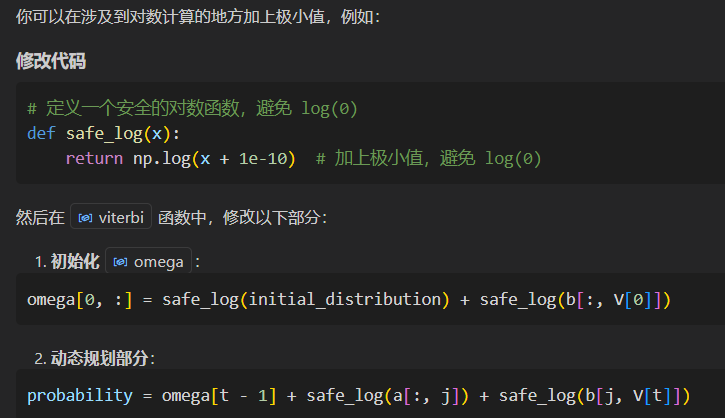

2，或者是直接修改原始矩阵：

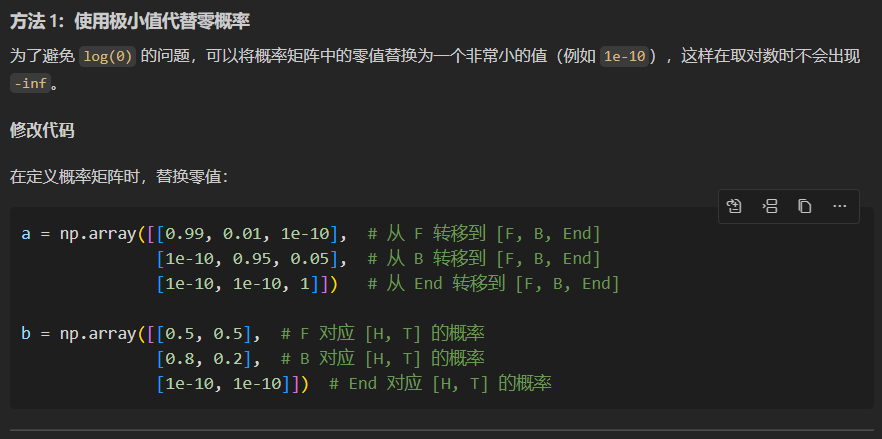

下面尝试方法1：

In [ ]:
def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
        
    def safe_log(x):
        return np.log(x + 1e-10)  # 避免 log(0)
        
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = safe_log(initial_distribution) + safe_log(b[:, V[0]])
    # np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 但是相乘后取对数容易导致下溢问题，也就是概率非常小，计算机无法准确表示，结果变为0，会产生-inf或数值错误，所以我们先取对数再相加，一保持数值精度
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] + safe_log(a[:, j]) + safe_log(b[j, V[t]])
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T, dtype=int) #隐状态序列初始化
    S[T - 1] = 1
    
    # 鉴于我们问题的特殊性，我在此处将会强制最后一个状态为 B,将最后一个状态设置为 B 的索引！！！！！！！1
    # np.argmax(omega[T - 1, :])  找到最后一步的最优状态，这个是理论上的
    # 因为依据我们上面的定义，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，此处获取最后一个时间步的最优状态index
    for t in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[t] = prev[t, S[t + 1]]
        # 前面的S[T-1]记录的是T-1时间步的最优状态；然后依此类推，S[T-2]记录的应该是T-2时间步的最优状态，然后一直一直到S[0]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，t的第一次loop是T-2，我们的式子是S[T-2]= prev[T-2,S[T-1]]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, S[t+1]]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        # 依此类推，接着就是S[T-3] = prev[T-3, S[T-2]]，S[T-4] = prev[T-4, S[T-3]]，直到S[0] = prev[0, S[1]]，即回溯到0时间步
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    # 如果你想表示序列结束后系统进入End状态，可以添加：！！！！！
    if result[-1] == "B":  # 如果最后一个状态是B
        result.append("End")  # 添加End作为额外状态
        
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数 
# 假设参数已正确定义


import numpy as np

def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print()

序列 1:
观测序列: TTHTHTHTHHHHTHTHTTHTTHHTTHTTTTHHHHTTTTTTHHTHTTTTHHHHHHHTTHHTTTHHHHTTHHTHTTHHHTTTHHHHHHHHHHHHTTHHHHHHTHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBEnd

序列 2:
观测序列: TTHTHHHHHHHHHHHHHHHHHTTHHTHHH
真实隐状态: FFFFBBBBBBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFBBBBBBBBBBBBBBBBBBBBBBBBBEnd

序列 3:
观测序列: TTHTHHHHHHHTTTHHTHHHTHHHTTTTTHHHHHHHTTTTHTHHHTHHTH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBEnd

序列 4:
观测序列: TTTHHHHHTHHTTHHHHHHHHTHHHHTHHHTHHHHHTHHHTTHHHHHH
真实隐状态: FFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBEnd

序列 5:
观测序列: HHHTHHTTHHHHHHHT
真实隐状态: FFFFFFFFBBBBBBBB
预测隐状态: FFFFFFFFBBBBBBBBEnd

序列 6:
观测序列: THTTTTTHTTHHHHHTTTTHHHHTHHTHTHTHHHTHTHTHHTHTTTTHTTTHHHTTTTTTHTTHTTHHHTTHHTHTTTHHTTTHT

下面试一试方法2：

In [ ]:
def viterbi(V, a, b, initial_distribution):
    # V，观测序列（可见状态序列），例如：[正面H，反面T，正面H，反面T]，也可以使用数字索引表示，如果正面是索引为0的状态，例如：[0, 1, 0, 1]——》假设观测序列长度为T，则V为1*T
    # a，状态转移概率矩阵，a[i][j]表示从隐状态i转移到隐状态j的概率——》假设隐状态数目为M，则a为M*M
    # b，发射概率矩阵/观测概率矩阵，b[j][k]表示从隐状态j观测到k的概率（或者由隐状态j生成观测k的概率）——》假设观测状态数目为N，则b为M*N
    # initial_distribution，初始状态概率分布，initial_distribution[i] 是初始时刻处于隐状态i的概率。例如：[0.5, 0.5]，表示隐状态0和隐状态1的初始概率分布——》假设隐状态数目为M，则initial_distribution为1*M
        
    T = V.shape[0] # 观测序列的长度（时间步总数），因为此处V为一维数组
    M = a.shape[0] # 隐状态的数量，因为此处a为一个二维数组，a.shape[0]表示行数，即隐状态的数量
    
    omega = np.zeros((T, M))
    # omega矩阵，形状为(T, M)，T为观测序列的长度，M为隐状态的数量
    # omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大概率，因为概率计算中有些乘积结果会非常小，为防止数值下溢，即结果小到无法被计算机准确表示，通常使用对数概率来代替概率
    # 因此，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，下面初始化/计算矩阵都使用对数概率
    
    omega[0, :] = np.log(initial_distribution) + np.log(b[:, V[0]])
    # np.log(initial_distribution * b[:, V[0]])
    # 初始化：omega[0][j] = log(初始状态j的概率 * 隐状态j生成观测V[0]的概率)，对应李航统计学习方法p209(1)初始化中δ1(i)的初始化计算
    # 但是相乘后取对数容易导致下溢问题，也就是概率非常小，计算机无法准确表示，结果变为0，会产生-inf或数值错误，所以我们先取对数再相加，一保持数值精度
    # 从维度上而言，initial_distribution是1*M，b[:, V[0]]是M*T（因为此处V[0]是1*T），两者相乘得到的是1*T的矩阵，T对应所有隐状态，表示初始时刻处于隐状态j且观测到V[0]的概率
    prev = np.zeros((T - 1, M))
    # 形状为 (T-1) x M，prev[t][j] 记录在时间t时，隐状态j的最优前驱状态（即从哪个状态转移而来）——》第t-1个节点，对应李航统计学习方法p209(1)中ψ1(i)=0的初始化
    for t in range(1, T):
        # 循环时间步：从t=1到t=T-1（因为t=0已初始化）
        for j in range(M):
            # 对每个隐状态j，计算在时刻t处于隐状态j的所有路径中的最大对数概率
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
            # 对应李航统计学习方法p209(2)中δt(j)=max[δt-1(j)aji]bi(ot)的计算，因为我们从omega即其他所有概率都是对数概率，所以原本数学推导中的乘法在这里变成了对数尺度下的加法
            # 具体来说：
            # probability 是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            # omega[t-1]：前一时间步各状态的最大概率，长度为M——》为 (M,)，实际上就是一维数组，没有行列概念，如果想要保持二维数组结构，需要参数reshape
            # a[:, j]：从前一时间步各状态转移到状态j的概率，长度为M——》也是(M,)，实际上就是一维数组，没有行列概念
            # b[j,V[t]]:状态j生成当前观测V[t]的发射概率——》为1*1
            # 以上三者相加，会通过广播机制自动对齐维度，得到的probability是一个长度为M的数组，表示从所有前驱状态i转移到j的概率
            
            
            omega[t, j] = np.max(probability) # 保存最大概率的对数值
            prev[t-1, j] = np.argmax(probability) # 记录使概率最大的前驱状态i，prev 记录的是时间步为t的最优前驱状态，时间步为t-1时的最优状态（对于1个时间步序列1到T，我们能够记录的是前驱时间步1到T-1）
            # 例如，当 T=5 时，时间步是1到5，我们能够记录的前驱是1到4，但是因为是0-based index，所以prev 的行索引应为 0 到 3（对应 t=1 到 t=4）
            
    # 回溯找到最优路径        
    S = np.zeros(T, dtype=int) #隐状态序列初始化
    S[T - 1] = 1
    
    # 鉴于我们问题的特殊性，我在此处将会强制最后一个状态为 B,将最后一个状态设置为 B 的索引！！！！！！！1
    # np.argmax(omega[T - 1, :])  找到最后一步的最优状态，这个是理论上的
    # 因为依据我们上面的定义，omega[t][j]表示在时刻t处于/到达隐状态j且观测到部分观测序列的所有路径中的最大对数概率，此处获取最后一个时间步的最优状态index
    for t in range(T - 2, -1, -1):
        # 逆向回溯：从时间步T-2到0（共T-1次转移），逐步找到前驱状态。
        S[t] = prev[t, S[t + 1]]
        # 前面的S[T-1]记录的是T-1时间步的最优状态；然后依此类推，S[T-2]记录的应该是T-2时间步的最优状态，然后一直一直到S[0]记录的是0时间步的最优状态（我们所谓的时间步都是0-based的，实际上对应的是T到1的时间步）
        # 我们直接从实例上代入看，t的第一次loop是T-2，我们的式子是S[T-2]= prev[T-2,S[T-1]]，
        # 因为依据我们上面的定义：prev[t-1, j]记录的是时间步为t的时候的最优前驱状态，也就是说索引是t-1记录的是t时刻的最优前驱状态
        # 所以这里的prev[T-2, S[t+1]]：记录的是T-1时刻的最优前驱状态，也就是时间T-2时的最优状态，所以没有问题
        # 依此类推，接着就是S[T-3] = prev[T-3, S[T-2]]，S[T-4] = prev[T-4, S[T-3]]，直到S[0] = prev[0, S[1]]，即回溯到0时间步
        # 对应李航统计学习方法p210(4)最优路径回溯中的递推公式：it*=ψt+1(it+1)*
        # 所以整个循环其实就是回溯时间步，找到每个时间步的最优前驱状态，然后记录这个前驱状态，并不断更新
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    # 如果你想表示序列结束后系统进入End状态，可以添加：！！！！！
    if result[-1] == "B":  # 如果最后一个状态是B
        result.append("End")  # 添加End作为额外状态
        
    return result

# 定义初始转移概率矩阵a，观测概率矩阵b，初始状态概率，观测序列，迭代次数 
# 假设参数已正确定义


import numpy as np

def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 1e-10],  # 从 F 转移到 [F, B, End]
              [1e-10, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [1e-10, 1e-10, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [1e-10, 1e-10]])     # End 对应 [H, T] 的概率
initial = np.array([1, 1e-10, 1e-10])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print()

序列 1:
观测序列: HTHTHTHHHTHTTTHTTTHHTTHHTTTHHTHTTTTTHTHHTHHTTTHTHTHTHTHTHHHTHTHTTTHTHHTTHTTHTTTTTHTTTTTTTTTTTTTHHHTTHTTHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBEnd

序列 2:
观测序列: TTTHHTHTTTHTHHTHTTHTHTTTHTTTHTHTTTHHTHTTHTHTHHHTHHTHHHHHHHHHHHHHTHHTTHHHHHHHTHHTH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBEnd

序列 3:
观测序列: HHHTHTHHHTTTTTTHTTTTHHHHHTTHTTTTTTHTTTTTHHTHTHTTTTHHHTTTTTTHTTTHHHTTHHHHHHTHHHTHTTHHHHHTHHHHHHTTTHTTHTHTTTTHTTTHTTHTTHHTHHHTTTTHTHTHTTHTHHHTHHHTHHHTTHHHHHHHTTTTTHHTHHTT
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBB
预测隐状态: FFFFFFFFFFF

In [81]:
import numpy as np

def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print()


序列 1:
观测序列: TTTHTHTHHHTTHHTHHHHHHHTTHHHHHHHHHHHTTTHHHHHTHTTHHHHH
真实隐状态: FFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBEnd

序列 2:
观测序列: HTHTHHHTTHHHTHTHHTTTHTHTHHTTHHTTTTTTTHTHTHTHTTTHHTHTTTTTTTTTTHHHHTHTTHHTTTHTTHTTTHTHHHTTHHHTTTTHHHTTHTHHHHHHTHTHHHHTHTTTTHTHHHHHHHTHHHTHTHHHHHHHHHHHHTTHHTHHHHHHHTHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBEnd

序列 3:
观测序列: THTHTHTHTHTTHHHTHHTTHTTTTTTTTHTTHHHTHTTTHTTHHHTTTHHTTHTTHHTHTHHTHHTH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBEnd

序列 4:
观测序列: THTTHHHHHHTHTTHTHHHTTTTTHTHTTTHHTH

/tmp/ipykernel_2709282/1438866002.py:15: RuntimeWarning: divide by zero encountered in log
  omega[0, :] = np.log(initial_distribution) + np.log(b[:, V[0]])
/tmp/ipykernel_2709282/1438866002.py:26: RuntimeWarning: divide by zero encountered in log
  probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])


下面是封装的过程，将整个程序写成一个函数：

In [94]:
import numpy as np
import re

def viterbi(V, a, b, initial_distribution):
    
    T = V.shape[0] 
    M = a.shape[0] 
    
    omega = np.zeros((T, M)) 
    omega[0, :] = initial_distribution * b[:, V[0]]
    prev = np.zeros((T - 1, M))
    for t in range(1, T):
        for j in range(M):
            probability = omega[t - 1] * a[:, j] * b[j, V[t]] 
            
            omega[t, j] = np.max(probability) 
            prev[t-1, j] = np.argmax(probability) 
     
    S = np.zeros(T, dtype=int)
    S[T - 1] = 1
    for t in range(T - 2, -1, -1):
        S[t] = prev[t, S[t + 1]]
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")  # 索引index为0对应的隐状态是F，fair，即投掷的为公平的第1枚硬币
        elif s == 1:
            result.append("B")  # 索引index为1对应的隐状态是B，biased，即投掷的为不公平的第2枚硬币
        else:
            result.append("End")  # 索引index为3对应的隐状态是End，也就是不扔了，结束
            
    if result[-1] == "B":  
        result.append("End")  
        
    return result

def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


def main(a,b,initial_state,num_lines):
    """
    Function:
    调用generate_random_sequence，在给定的参数a、b、initial_state下，随机生成num_lines行的观测序列，同时保留真实隐状态序列作为参考，然后再调用viterbi函数，
    预测隐状态序列，并打印出观测序列、真实隐状态序列和预测隐状态序列，以及第一个B状态的index在哪里（针对预测而言）

    Args:
    a: 状态转移概率矩阵 
    b: 观测概率矩阵 
    initial_state: 初始状态概率 
    num_lines: 生成的观测序列行数

    Return:
    一系列的提示信息，比如说
    我们所生成的随机序列是什么，真实的隐状态是什么，预测的隐状态是什么，然后第一个B状态的index在哪里（针对预测而言）
    """

# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print(f"第一个B状态的index: {re.search('B', ''.join(predicted_states)).start() }")

序列 1:
观测序列: TTTHTHTHHHHTTTTTTTHHHTTTHHTHTTHHHTTTHHTTTTHTHTHTTTTTTHHTHHHHTHHHHTTHHHHHHHHHHT
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBEnd
第一个B状态的index: 56
序列 2:
观测序列: THTTTHHTHTHHTTTHTHHHTTTHHHHHHTTTHTTTHTTHTHTTTHTTTTHHHTTTHHTTHTHTTHTHHTHHHHTHHHHTHTTHTTTTHHHHHTTHTHTHTTTHTHTHHHHTHTHTTTTTHHHTTTTTHTHHHHHHHHTTTTTTTHTTTHHTHTTHTHTTTHHHHTTTHTHHTHHTTHHTTHHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBEnd
第一个B状态的index: 181
序列 3:
观测序列: HHTTHTTTHHTTTHTHHTTHHHHTTHHHTHHHTTHHTTTHHHTHHTTTTHHHHTTTTHTTHHTHHHTTTTTHTHHHHHTHHHHTHTTHTHHHHHHTHHHH

下面是对算法中强制引入最后一个隐状态B的时候，可能会导致在中间回溯的时候出现

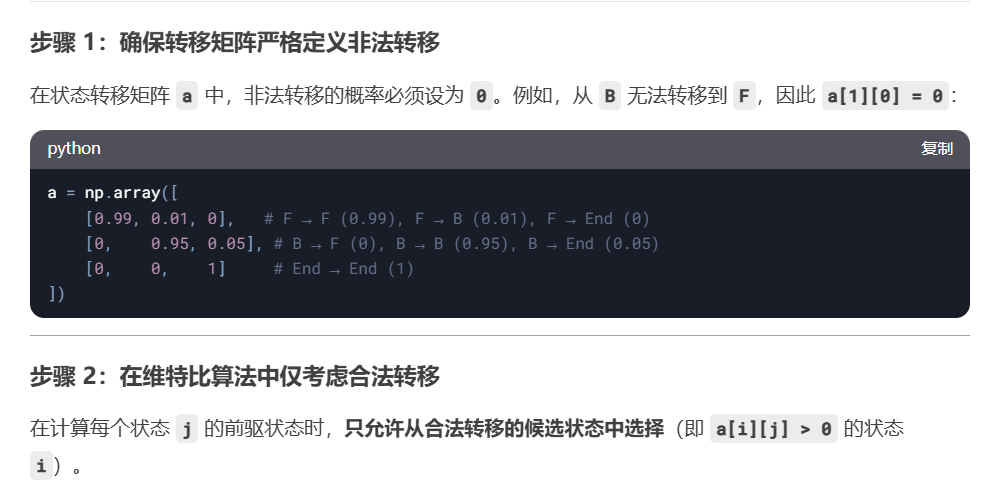

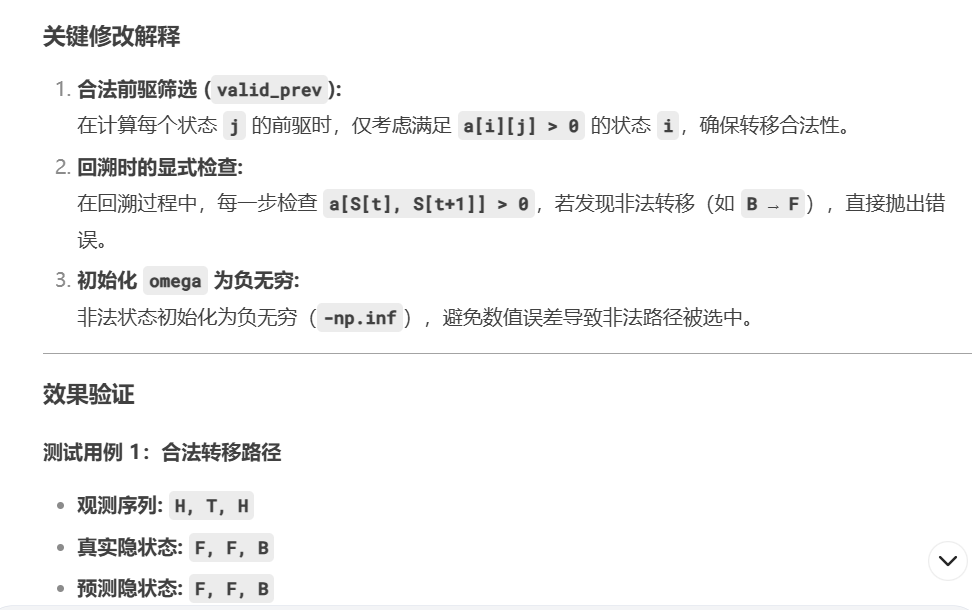

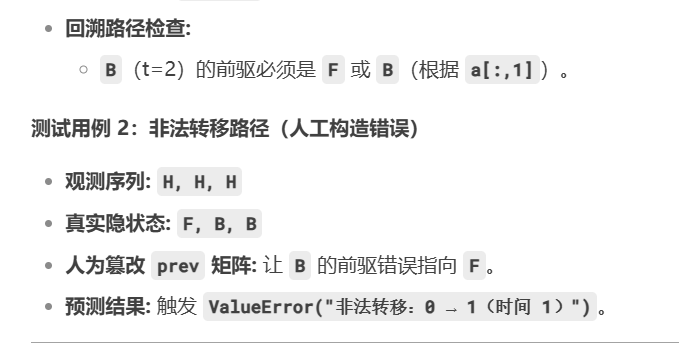

In [96]:
def viterbi(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
    omega = np.zeros((T, M))  
    omega[0, :] = initial_distribution * b[:, V[0]] 

    prev = np.zeros((T-1, M), dtype=int)
    for t in range(1, T):
        for j in range(M):
            # 只考虑合法转移的前驱状态（a[i][j] > 0）
            valid_prev = np.where(a[:, j] > 0)[0]
            if len(valid_prev) == 0:
                raise ValueError(f"状态 {j} 在时间 {t} 无合法前驱！")
            # 计算合法前驱的概率
            prob = omega[t-1, valid_prev] * a[valid_prev, j] * b[j, V[t]] 
            max_idx = np.argmax(prob)
            omega[t, j] = prob[max_idx]
            prev[t-1, j] = valid_prev[max_idx]  # 记录合法前驱

    # 强制最后一个状态为 B
    S = np.zeros(T, dtype=int)
    S[-1] = 1  # B 的索引为 1

    # 回溯并检查转移合法性
    for t in range(T-2, -1, -1):
        current_state = S[t+1]
        S[t] = prev[t, current_state]
        # 显式检查转移是否合法
        if a[S[t], current_state] <= 0:
            raise ValueError(f"非法转移：{S[t]} → {current_state}（时间 {t})")

    return ["F" if s == 0 else "B" for s in S]


def generate_random_sequence(a, b, initial, num_lines=100):
    """
    随机生成观测序列和隐状态序列。
    :param a: 状态转移概率矩阵 (3x3)
    :param b: 观测概率矩阵 (3x2)
    :param initial: 初始状态概率 (1x3)
    :param num_lines: 生成的观测序列行数
    :return: 观测序列列表和隐状态序列列表
    """
    # 隐状态和观测值的映射
    states = ["F", "B", "End"]  # 隐状态
    observations = ["H", "T"]  # 观测值

    # 存储生成的观测序列和隐状态序列
    observation_sequences = []  # 存储观测序列
    state_sequences = []  # 存储隐状态序列

    for _ in range(num_lines):
        obs_seq = []  # 当前行的观测序列
        state_seq = []  # 当前行的隐状态序列

        # 初始状态
        current_state = np.random.choice(len(states), p=initial)  # 根据初始状态概率选择状态

        while current_state != 2:  # 当状态不是 "End" 时
            # 根据当前状态生成观测值
            current_observation = np.random.choice(len(observations), p=b[current_state])
            obs_seq.append(observations[current_observation])  # 添加观测值
            state_seq.append(states[current_state])  # 添加隐状态

            # 根据状态转移概率选择下一个状态
            current_state = np.random.choice(len(states), p=a[current_state])

        # 将生成的序列存储到结果列表中
        observation_sequences.append("".join(obs_seq))
        state_sequences.append("".join(state_seq))

    return observation_sequences, state_sequences


def main(a,b,initial_state,num_lines):
    """
    Function:
    调用generate_random_sequence，在给定的参数a、b、initial_state下，随机生成num_lines行的观测序列，同时保留真实隐状态序列作为参考，然后再调用viterbi函数，
    预测隐状态序列，并打印出观测序列、真实隐状态序列和预测隐状态序列，以及第一个B状态的index在哪里（针对预测而言）

    Args:
    a: 状态转移概率矩阵 
    b: 观测概率矩阵 
    initial_state: 初始状态概率 
    num_lines: 生成的观测序列行数

    Return:
    一系列的提示信息，比如说
    我们所生成的随机序列是什么，真实的隐状态是什么，预测的隐状态是什么，然后第一个B状态的index在哪里（针对预测而言）
    """

# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用函数生成观测序列和隐状态序列
obs_sequences, state_sequences = generate_random_sequence(a, b, initial, num_lines=10)

# 验证维特比算法
obs_states = {"H":0,"T":1}  # 此处为观测序列哑变量编码
for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
    V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
    predicted_states = viterbi(V, a, b, initial)  # 使用维特比算法预测隐状态序列

    print(f"序列 {i + 1}:")
    print(f"观测序列: {obs}")
    print(f"真实隐状态: {true_states}")
    print(f"预测隐状态: {''.join(predicted_states)}")
    print(f"第一个B状态的index: {re.search('B', ''.join(predicted_states)).start() }")

序列 1:
观测序列: TTHTHTTHTHHHTTTHTTHTHTTTHHTTHHHTHHHTTTTTTTTTHHTTHTHHHTHTTTHTHHHHHHHHTTHTHTTTTHTTHHHHHTHTHHHHHTTHHTTTHTHHTTTHTHTHTHTTHTHHTHHHTTHTHHHHTHHHTHHTTHHHTTHHHTHTHTTTTHHTTTTTHTTHTTTTTTTTTHTHHTTTHTHTHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBB
第一个B状态的index: 188
序列 2:
观测序列: HTHTHHHTHHTHTTTTHHTTTHTHTHHTTTHHHHHTTTTHHHTTHHTTTHTTHHTHHHTTHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBB
第一个B状态的index: 60
序列 3:
观测序列: HTHHHHTTHHHTHTHHTTHHHTTHHHTHTHHTTHTHHHHTHHHHHHHHHTHHHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFF

In [99]:
import numpy as np
import re

def viterbi(V, a, b, initial_distribution):
    T = V.shape[0] 
    M = a.shape[0] 
    
    omega = np.zeros((T, M)) 
    omega[0, :] = initial_distribution * b[:, V[0]]
    prev = np.zeros((T - 1, M))
    for t in range(1, T):
        for j in range(M):
            probability = omega[t - 1] * a[:, j] * b[j, V[t]] 
            
            omega[t, j] = np.max(probability) 
            prev[t-1, j] = np.argmax(probability) 
     
    S = np.zeros(T, dtype=int)
    S[T - 1] = 1
    for t in range(T - 2, -1, -1):
        S[t] = prev[t, S[t + 1]]
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")
        elif s == 1:
            result.append("B")
        else:
            result.append("End")
        
    return result, S  # 返回预测的状态序列和索引

def forward(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
    
    alpha = np.zeros((T, M))
    alpha[0, :] = initial_distribution * b[:, V[0]]
    
    for t in range(1, T):
        for j in range(M):
            alpha[t, j] = np.sum(alpha[t - 1] * a[:, j]) * b[j, V[t]]
    
    return alpha

def backward(V, a, b):
    T = V.shape[0]
    M = a.shape[0]
    
    beta = np.zeros((T, M))
    beta[T - 1, :] = 1  # 初始化最后一步的后向概率为1
    
    for t in range(T - 2, -1, -1):
        for i in range(M):
            beta[t, i] = np.sum(beta[t + 1] * a[i, :] * b[:, V[t + 1]])
    
    return beta

def posterior(alpha, beta):
    posterior_probs = alpha * beta
    posterior_probs /= np.sum(posterior_probs, axis=1, keepdims=True)  # 归一化
    return posterior_probs

def evaluate_prediction(V, predicted_indices, a, b, initial_distribution):
    """
    对预测的隐状态序列进行后验概率计算，并输出后验概率最大的5个时间步。
    """
    # 计算前向概率
    alpha = forward(V, a, b, initial_distribution)
    
    # 计算后向概率
    beta = backward(V, a, b)
    
    # 计算后验概率
    posterior_probs = posterior(alpha, beta)
    
    # 计算预测序列的后验概率
    predicted_posterior_probs = posterior_probs[np.arange(len(predicted_indices)), predicted_indices]
    
    # 找到后验概率最大的5个时间步
    max_indices = np.argsort(-predicted_posterior_probs)[:5]
    
    print(f"预测序列的后验概率: {predicted_posterior_probs}")
    print(f"后验概率最大的5个时间步索引: {max_indices}")
    print(f"对应的后验概率: {predicted_posterior_probs[max_indices]}")

def main(a, b, initial_state, num_lines):
    obs_sequences, state_sequences = generate_random_sequence(a, b, initial_state, num_lines)
    obs_states = {"H": 0, "T": 1}
    
    for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
        V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
        predicted_states, predicted_indices = viterbi(V, a, b, initial_state)  # 使用维特比算法预测隐状态序列
        
        print(f"序列 {i + 1}:")
        print(f"观测序列: {obs}")
        print(f"真实隐状态: {true_states}")
        print(f"预测隐状态: {''.join(predicted_states)}")
        print(f"第一个B状态的index: {re.search('B', ''.join(predicted_states)).start()}")
        
        # 评估预测序列的后验概率
        evaluate_prediction(V, predicted_indices, a, b, initial_state)
        print()

# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用主函数
main(a, b, initial, num_lines=10)

序列 1:
观测序列: TTTTHHHHHTTTHTTHHHHHTHHHTTHHTHTHTHTHTHHHHTTHTTHHHTHHHTHHTHTTHHTTHTHHTHTHTTHTTTHHTHTHHHHHTHHTTHTTTHTHHTTHTHHHTHTHTTHHHTTHTHHTTTHTHHHTHTHTHTHHHTTHHTTHTTTHTHHHHTHTTTTTHHTHTHHHHHHHTHHHHHHT
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBB
第一个B状态的index: 169
预测序列的后验概率: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.

下面是要看后验概率高还是低，就是看自己预测出来的模型，是不是状态有差异的地方，会导致后验概率低，就是看一看

并且去掉了强制最后一位是B的限制

In [103]:
import numpy as np
import re

def viterbi(V, a, b, initial_distribution):
    T = V.shape[0] 
    M = a.shape[0] 
    
    omega = np.zeros((T, M)) 
    omega[0, :] = initial_distribution * b[:, V[0]]
    prev = np.zeros((T - 1, M))
    for t in range(1, T):
        for j in range(M):
            probability = omega[t - 1] * a[:, j] * b[j, V[t]] 
            
            omega[t, j] = np.max(probability) 
            prev[t-1, j] = np.argmax(probability) 
     
    S = np.zeros(T, dtype=int)
    S[T - 1] = np.argmax(omega[T - 1, :])  # 找到最后一步的最优状态
    for t in range(T - 2, -1, -1):
        S[t] = prev[t, S[t + 1]]
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")
        elif s == 1:
            result.append("B")
        else:
            result.append("End")
        
    return result, S  # 返回预测的状态序列和索引

def forward(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
    
    alpha = np.zeros((T, M))
    alpha[0, :] = initial_distribution * b[:, V[0]]
    
    for t in range(1, T):
        for j in range(M):
            alpha[t, j] = np.sum(alpha[t - 1] * a[:, j]) * b[j, V[t]]
    
    return alpha

def backward(V, a, b):
    T = V.shape[0]
    M = a.shape[0]
    
    beta = np.zeros((T, M))
    beta[T - 1, :] = 1  # 初始化最后一步的后向概率为1
    
    for t in range(T - 2, -1, -1):
        for i in range(M):
            beta[t, i] = np.sum(beta[t + 1] * a[i, :] * b[:, V[t + 1]])
    
    return beta

def posterior(alpha, beta):
    posterior_probs = alpha * beta
    posterior_probs /= np.sum(posterior_probs, axis=1, keepdims=True)  # 归一化
    return posterior_probs

def evaluate_prediction(V, predicted_indices, true_indices, a, b, initial_distribution):
    """
    对预测的隐状态序列进行后验概率计算，并输出：
    1. 后验概率最大的5个时间步。
    2. 后验概率最低的5个时间步。
    3. 预测序列与真实序列不一致的位置及其后验概率。
    """
    # 计算前向概率
    alpha = forward(V, a, b, initial_distribution)
    
    # 计算后向概率
    beta = backward(V, a, b)
    
    # 计算后验概率
    posterior_probs = posterior(alpha, beta)
    
    # 计算预测序列的后验概率
    predicted_posterior_probs = posterior_probs[np.arange(len(predicted_indices)), predicted_indices]
    
    # 找到后验概率最大的5个时间步
    max_indices = np.argsort(-predicted_posterior_probs)[:5]
    
    # 找到后验概率最低的5个时间步
    min_indices = np.argsort(predicted_posterior_probs)[:5]
    
    # 找到预测序列与真实序列不一致的位置
    mismatch_indices = np.where(predicted_indices != true_indices)[0]
    mismatch_probs = predicted_posterior_probs[mismatch_indices]
    
    print(f"预测序列的后验概率: {predicted_posterior_probs}")
    print(f"后验概率最大的5个时间步索引: {max_indices}")
    print(f"对应的后验概率: {predicted_posterior_probs[max_indices]}")
    print(f"后验概率最低的5个时间步索引: {min_indices}")
    print(f"对应的后验概率: {predicted_posterior_probs[min_indices]}")
    print(f"预测与真实不一致的位置索引: {mismatch_indices}")
    print(f"对应的后验概率: {mismatch_probs}")

def main(a, b, initial_state, num_lines):
    obs_sequences, state_sequences = generate_random_sequence(a, b, initial_state, num_lines)
    obs_states = {"H": 0, "T": 1}
    state_mapping = {"F": 0, "B": 1, "End": 2}
    
    for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
        V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
        true_indices = np.array([state_mapping[state] for state in true_states])  # 将真实隐状态序列转换为数字索引
        predicted_states, predicted_indices = viterbi(V, a, b, initial_state)  # 使用维特比算法预测隐状态序列
        
        print(f"序列 {i + 1}:")
        print(f"观测序列: {obs}")
        print(f"真实隐状态: {true_states}")
        print(f"预测隐状态: {''.join(predicted_states)}")
        
        # 评估预测序列的后验概率
        evaluate_prediction(V, predicted_indices, true_indices, a, b, initial_state)
        print()

# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用主函数
main(a, b, initial, num_lines=10)

序列 1:
观测序列: HTTTHTHHHTTTHHTTTHTHTHTHTHTHTHTTHHHTTTHHHHTHHTHHHHHTHHTTTTTHHTHTHTHTHTTTTHHTHHHTTHTTHHTHTTTTHHTHHTHHHHTHTHHTTTTHHHHHTTHTHTTHTTTHTHTTTTTTTTHHHHTHHTTHHHTHHHTTTTTHHHTTHHTHHHHTHTHTHTTHTHTTTTTHHHTHHHHTHHTTHHTTHHHHHTHHHTTTHHHHHTHHTHHTHTTTTTTTTTHTTHHHHTTHTTHHHHHHHTTTHHTHTHTTHTTTTHTHTTHHTHHTTHTTH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
预测序列的后验概率: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         

基本上我们能够看到，状态序列比对不上的地方，其实基本上就是后验概率最低的地方

下面还是恢复最后一个位置B的限制

In [104]:
import numpy as np
import re

def viterbi(V, a, b, initial_distribution):
    T = V.shape[0] 
    M = a.shape[0] 
    
    omega = np.zeros((T, M)) 
    omega[0, :] = initial_distribution * b[:, V[0]]
    prev = np.zeros((T - 1, M))
    for t in range(1, T):
        for j in range(M):
            probability = omega[t - 1] * a[:, j] * b[j, V[t]] 
            
            omega[t, j] = np.max(probability) 
            prev[t-1, j] = np.argmax(probability) 
     
    S = np.zeros(T, dtype=int)
    S[T - 1] = 1  # 找到最后一步的最优状态
    for t in range(T - 2, -1, -1):
        S[t] = prev[t, S[t + 1]]
        
    result = []
    for s in S:
        if s == 0:
            result.append("F")
        elif s == 1:
            result.append("B")
        else:
            result.append("End")
        
    return result, S  # 返回预测的状态序列和索引

def forward(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
    
    alpha = np.zeros((T, M))
    alpha[0, :] = initial_distribution * b[:, V[0]]
    
    for t in range(1, T):
        for j in range(M):
            alpha[t, j] = np.sum(alpha[t - 1] * a[:, j]) * b[j, V[t]]
    
    return alpha

def backward(V, a, b):
    T = V.shape[0]
    M = a.shape[0]
    
    beta = np.zeros((T, M))
    beta[T - 1, :] = 1  # 初始化最后一步的后向概率为1
    
    for t in range(T - 2, -1, -1):
        for i in range(M):
            beta[t, i] = np.sum(beta[t + 1] * a[i, :] * b[:, V[t + 1]])
    
    return beta

def posterior(alpha, beta):
    posterior_probs = alpha * beta
    posterior_probs /= np.sum(posterior_probs, axis=1, keepdims=True)  # 归一化
    return posterior_probs

def evaluate_prediction(V, predicted_indices, true_indices, a, b, initial_distribution):
    """
    对预测的隐状态序列进行后验概率计算，并输出：
    1. 后验概率最大的5个时间步。
    2. 后验概率最低的5个时间步。
    3. 预测序列与真实序列不一致的位置及其后验概率。
    """
    # 计算前向概率
    alpha = forward(V, a, b, initial_distribution)
    
    # 计算后向概率
    beta = backward(V, a, b)
    
    # 计算后验概率
    posterior_probs = posterior(alpha, beta)
    
    # 计算预测序列的后验概率
    predicted_posterior_probs = posterior_probs[np.arange(len(predicted_indices)), predicted_indices]
    
    # 找到后验概率最大的5个时间步
    max_indices = np.argsort(-predicted_posterior_probs)[:5]
    
    # 找到后验概率最低的5个时间步
    min_indices = np.argsort(predicted_posterior_probs)[:5]
    
    # 找到预测序列与真实序列不一致的位置
    mismatch_indices = np.where(predicted_indices != true_indices)[0]
    mismatch_probs = predicted_posterior_probs[mismatch_indices]
    
    print(f"预测序列的后验概率: {predicted_posterior_probs}")
    print(f"后验概率最大的5个时间步索引: {max_indices}")
    print(f"对应的后验概率: {predicted_posterior_probs[max_indices]}")
    print(f"后验概率最低的5个时间步索引: {min_indices}")
    print(f"对应的后验概率: {predicted_posterior_probs[min_indices]}")
    print(f"预测与真实不一致的位置索引: {mismatch_indices}")
    print(f"对应的后验概率: {mismatch_probs}")

def main(a, b, initial_state, num_lines):
    obs_sequences, state_sequences = generate_random_sequence(a, b, initial_state, num_lines)
    obs_states = {"H": 0, "T": 1}
    state_mapping = {"F": 0, "B": 1, "End": 2}
    
    for i, (obs, true_states) in enumerate(zip(obs_sequences, state_sequences)):
        V = np.array([obs_states[char] for char in obs])  # 将观测序列转换为数字索引
        true_indices = np.array([state_mapping[state] for state in true_states])  # 将真实隐状态序列转换为数字索引
        predicted_states, predicted_indices = viterbi(V, a, b, initial_state)  # 使用维特比算法预测隐状态序列
        
        print(f"序列 {i + 1}:")
        print(f"观测序列: {obs}")
        print(f"真实隐状态: {true_states}")
        print(f"预测隐状态: {''.join(predicted_states)}")
        
        # 评估预测序列的后验概率
        evaluate_prediction(V, predicted_indices, true_indices, a, b, initial_state)
        print()

# 定义状态转移概率矩阵、观测概率矩阵和初始状态概率
a = np.array([[0.99, 0.01, 0],  # 从 F 转移到 [F, B, End]
              [0, 0.95, 0.05],  # 从 B 转移到 [F, B, End]
              [0, 0, 1]])       # 从 End 转移到 [F, B, End]，且End状态应停留在自身
b = np.array([[0.5, 0.5],  # F 对应 [H, T] 的概率
              [0.8, 0.2],  # B 对应 [H, T] 的概率
              [0, 0]])     # End 对应 [H, T] 的概率
initial = np.array([1, 0, 0])  # 初始状态概率，对应 [F, B, End]

# 调用主函数
main(a, b, initial, num_lines=10)

序列 1:
观测序列: HTTTTHHTHHHHHHHTTTHHHHHTHHHTTTTHTTTTHHTTHTHTTHTHHTHHHTHHHHHHHHHHHHHHHHTHHHHTHTHHHHHHHHHHHHHHTHTHHHTHHTHHHH
真实隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
预测隐状态: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
预测序列的后验概率: [1.         0.99999939 0.99999781 0.9999937  0.99998298 0.99995506
 0.99993688 0.99992503 0.99989418 0.99987408 0.99986099 0.99985246
 0.99984691 0.99984329 0.99984094 0.9998394  0.99983541 0.99982499
 0.99979786 0.99978019 0.99976868 0.99976119 0.99975631 0.99975313
 0.99974484 0.99973945 0.99973593 0.99973364 0.99972768 0.99971214
 0.99967167 0.99956622 0.99949754 0.99931861 0.99885244 0.99763796
 0.99447392 0.99241313 0.9910709  0.98757406 0.97846384 0.97253022
 0.95707156 0.94700309 0.92077209 0.85243342 0.80792336 0.69196295
 0.6164361  0.56724428 0.56091338 0.64438449 0.69875053 0.73416
 0.82641098 0.88649549 0.92562949 0.951118

In [1]:
import numpy as np

# 定义变量
T = 5  # 观测序列长度
M = 3  # 隐状态数量
omega = np.random.rand(T, M)  # 随机初始化 omega
a = np.random.rand(M, M)  # 随机初始化转移概率矩阵
b = np.random.rand(M, 4)  # 随机初始化观测概率矩阵
V = np.random.randint(0, 4, size=T)  # 随机生成观测序列

# 计算 probability
t = 1
j = 2
probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
print("omega[t - 1]:", omega[t - 1].shape)  # (M,)
print("np.log(a[:, j]):", np.log(a[:, j]).shape)  # (M,)
print("np.log(b[j, V[t]]):", np.log(b[j, V[t]]).shape)  # ()
print("probability:", probability.shape)  # (M,)

omega[t - 1]: (3,)
np.log(a[:, j]): (3,)
np.log(b[j, V[t]]): ()
probability: (3,)
